# Importing libraries

In [1]:
import cv2
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt

%matplotlib inline

# RMSE

In [2]:
def RMSE(img, transformed_img):
    MSE_value = np.square(np.subtract(img, transformed_img)).mean() 
    RMSE_value = np.sqrt(MSE_value)
    return RMSE_value

# DCT

In [3]:
def dct2(a):
    return fftpack.dct( fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return fftpack.idct(fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

# Plot image

In [4]:
def plotter(image, transformed_image):
    
    plt.figure(figsize=(8,8))
    plt.imshow(image ,cmap='gray')
    plt.title("original image" );
    plt.show()

    plt.figure(figsize=(8,8))
    plt.imshow(transformed_image ,cmap='gray')
    plt.title("Compressed image" );
    plt.show()
    

## Zonal

In [5]:
def BTF_DCT_zonal(image , blocksize, showplot= False):
    
    def zone_create(size):
        zone = np.ndarray((size, size))
        counter = 0
        for i in range(0, int(size)):
            for j in range(0, int(size)):
                if j < ((int(size))/2)-counter :
                    zone[i, j] = True
                else:
                    zone[i, j] = False
            counter = counter + 1
        return zone

    # Zonal coding
    zone = zone_create(blocksize)
    
    imagesize = image.shape
    dct_zonal = np.zeros(imagesize)

    # Do blocksize x blocksize DCT on image (in-place)
    for X in np.r_[:imagesize[0]:blocksize]:
        for Y in np.r_[:imagesize[1]:blocksize]:
            im = dct2( image[X:(X+blocksize),Y:(Y+blocksize)] )
            oneDarray = np.asarray(im).flatten()
            dct_zonal[X:(X+blocksize),Y:(Y+blocksize)] = im * zone
    
    
    percent_nonzeros = np.sum( dct_zonal != 0.0 ) / (imagesize[0]*imagesize[1]*1.0)
    print ("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
    

    image_dct = np.zeros(imagesize)
    rmse_block = []
    
    for X in np.r_[:imagesize[0]:blocksize]:
        for Y in np.r_[:imagesize[1]:blocksize]:
            rmse_block.append(RMSE(image[X:(X+blocksize),Y:(Y+blocksize)], idct2(dct_zonal[X:(X+blocksize),Y:(Y+blocksize)])))
            image_dct[X:(X+blocksize),Y:(Y+blocksize)] = idct2( dct_zonal[X:(X+blocksize),Y:(Y+blocksize)] )

    print(f"For blocksize ={blocksize} zonal coding \n  MEAN RMSE BLOCK = {np.mean(rmse_block)}")
    print("_"*50+"\n")
    
    if showplot == True:
        plotter(image, image_dct)
    
    return [image_inverse, np.mean(rmse_block)]


## Stable threshold

In [6]:
def BTF_DCT_stable_threshold(image , blocksize, thresh_value, showplot=False):
    
    imagesize = image.shape
    dct = np.zeros(imagesize)
    
    # Do block size x block size DCT on image (in-place)
    for X in np.r_[:imagesize[0]:blocksize]:
        for Y in np.r_[:imagesize[1]:blocksize]:
            dct[X :(X +blocksize),Y :(Y +blocksize)] = dct2( image[X :(X +blocksize),Y :(Y +blocksize)] )
    
    # Threshold
    dct_thresh = dct * (np.abs(dct) > (thresh_value*np.max(dct)))

    percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imagesize[0]*imagesize[1]*1.0)
    print ("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
    
    image_dct = np.zeros(imagesize)
    rmse_block = []
    for X in np.r_[:imagesize[0]:blocksize]:
        for Y in np.r_[:imagesize[1]:blocksize]:
            rmse_block.append(RMSE(image[X:(X+blocksize),Y:(Y+blocksize)], idct2(dct_thresh[X:(X+blocksize),Y:(Y+blocksize)])))
            image_dct[X:(X+blocksize),Y:(Y+blocksize)] = idct2( dct_thresh[X:(X+blocksize),Y:(Y+blocksize)] )
            
    print(f"For blocksize ={blocksize} and threshvalue = {thresh_value}\n stabel thresh MEAN RMSE BLOCK = {np.mean(rmse_block)}")
    print("_"*50+"\n")
    
    if showplot == True:
        plotter(image, image_dct)
    
    return [image_dct, np.mean(rmse_block)]

## Adaptive threshold

In [7]:
def BTC_DCT_adaptive_threshold(image , blocksize , percentage, showplot=False):
    
    imagesize = image.shape
    dct_thresh = np.zeros(imagesize)
    
    # Do block size x block size DCT on image (in-place)
    for X in np.r_[:imagesize[0]:blocksize]:
        for Y in np.r_[:imagesize[1]:blocksize]:
            im = dct2( image[X:(X+blocksize),Y:(Y+blocksize)] )
            oneDarray = np.asarray(np.abs(im)).flatten()
            dct_thresh[X:(X+blocksize),Y:(Y+blocksize)] = im * (np.abs(im) > (oneDarray[int(percentage/100*oneDarray.shape[0])]))

    percent_nonzeros = np.sum( dct_thresh != 0.0 ) / (imagesize[0]*imagesize[1]*1.0)

    print ("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))
    
    image_dct = np.zeros(imagesize)
    rmse_block = []
    for X in np.r_[:imagesize[0]:blocksize]:
        for Y in np.r_[:imagesize[1]:blocksize]:
            rmse_block.append(RMSE(image[X:(X+blocksize),Y:(Y+blocksize)],idct2( dct_thresh[X:(X+blocksize),Y:(Y+blocksize)])))
            image_dct[X:(X+blocksize),Y:(Y+blocksize)] = idct2( dct_thresh[X:(X+blocksize),Y:(Y+blocksize)] )
    
    print(f"For blocksize ={blocksize} and threshpercentage = {percentage}\n adaptive thresh MEAN RMSE BLOCK = {np.mean(rmse_block)}")
    print("_"*50+"\n")
    
    if showplot == True:
        plotter(image, image_dct)
        
    return [image_dct, np.mean(rmse_block)]

## Reading test image

In [8]:
barbara = cv2.imread("barbara.bmp", 0).astype(float)

# Results

Keeping only 10.890579% of the DCT coefficients
For blocksize =8 and threshvalue = 0.012
 stabel thresh MEAN RMSE BLOCK = 4.692266477927962
__________________________________________________



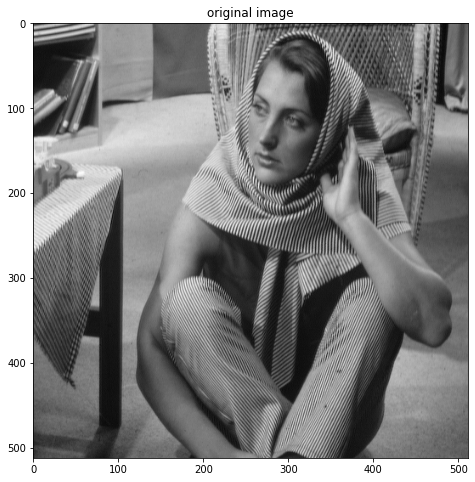

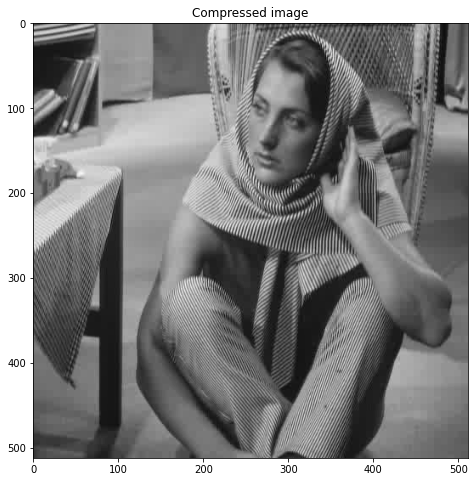

In [9]:
BTF_DCT_stable_threshold(barbara, 8 , 0.012 , True);

Keeping only 37.411118% of the DCT coefficients
For blocksize =8 and threshpercentage = 30
 adaptive thresh MEAN RMSE BLOCK = 3.792766330890233
__________________________________________________



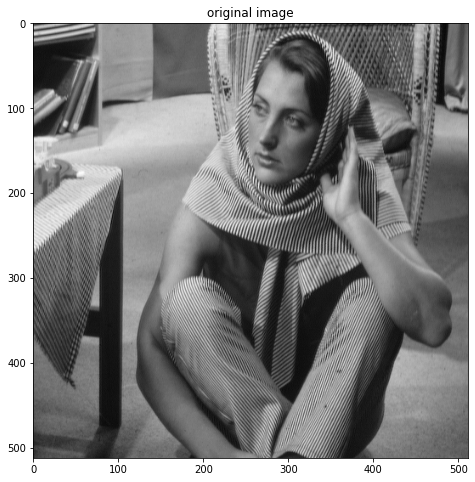

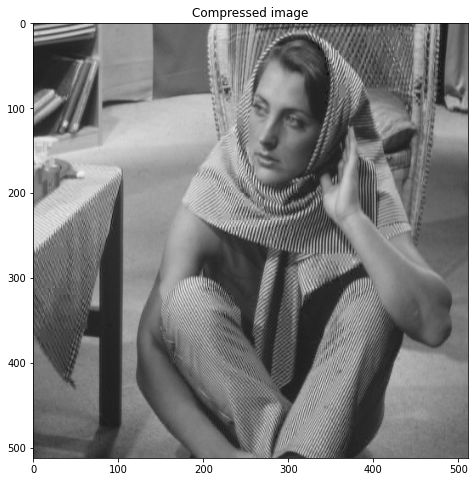

In [10]:
BTC_DCT_adaptive_threshold(barbara, 8 , 30, True);

Keeping only 15.625000% of the DCT coefficients
For blocksize =8 zonal coding 
  MEAN RMSE BLOCK = 9.844064890736565
__________________________________________________



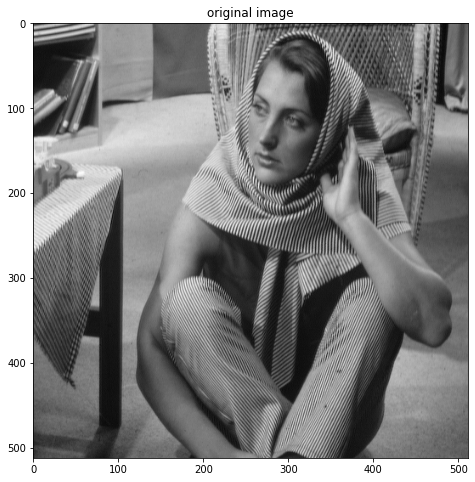

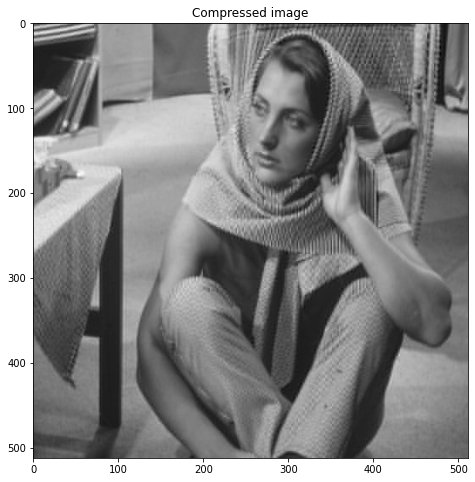

In [11]:
BTF_DCT_zonal(barbara, 8, True);

### Total RMSE and Mean block RMSE for each method and with various window sizes

- Stable threshold

In [42]:
y_thresh_stable = [[RMSE(barbara, BTF_DCT_stable_threshold(barbara, 2 , 0.12 )[0]), 
                    RMSE(barbara, BTF_DCT_stable_threshold(barbara, 4 , 0.012 )[0]),
                    RMSE(barbara, BTF_DCT_stable_threshold(barbara, 8 , 0.012 )[0]),
                    RMSE(barbara, BTF_DCT_stable_threshold(barbara, 16 , 0.0012 )[0]),
                    RMSE(barbara, BTF_DCT_stable_threshold(barbara, 32 , 0.0012 )[0])]]



y_thresh_stable_MEAN_RMSE_BLOCK = [[BTF_DCT_stable_threshold(barbara, 2 , 0.12 )[1], 
                                    BTF_DCT_stable_threshold(barbara, 4 , 0.012 )[1],
                                    BTF_DCT_stable_threshold(barbara, 8 , 0.012 )[1],
                                    BTF_DCT_stable_threshold(barbara, 16 , 0.0012 )[1],
                                    BTF_DCT_stable_threshold(barbara, 32 , 0.0012 )[1]]]

Keeping only 26.216507% of the DCT coefficients
For blocksize =2 and threshvalue = 0.12
 stabel thresh MEAN RMSE BLOCK = 7.015716084627386
__________________________________________________

Keeping only 23.870850% of the DCT coefficients
For blocksize =4 and threshvalue = 0.012
 stabel thresh MEAN RMSE BLOCK = 2.953287673630273
__________________________________________________

Keeping only 10.890579% of the DCT coefficients
For blocksize =8 and threshvalue = 0.012
 stabel thresh MEAN RMSE BLOCK = 4.692266477927962
__________________________________________________

Keeping only 33.588791% of the DCT coefficients
For blocksize =16 and threshvalue = 0.0012
 stabel thresh MEAN RMSE BLOCK = 1.4791912498132553
__________________________________________________

Keeping only 21.194077% of the DCT coefficients
For blocksize =32 and threshvalue = 0.0012
 stabel thresh MEAN RMSE BLOCK = 2.482715566818269
__________________________________________________

Keeping only 26.216507% of the DCT c

In [43]:
y_zonal = [[RMSE(barbara,BTF_DCT_zonal(barbara, 2)[0]),
           RMSE(barbara,BTF_DCT_zonal(barbara, 4)[0]),
           RMSE(barbara,BTF_DCT_zonal(barbara, 8)[0]),
           RMSE(barbara,BTF_DCT_zonal(barbara, 16)[0]),
           RMSE(barbara,BTF_DCT_zonal(barbara, 32)[0])]]



y_zonal_MEAN_RMSE_BLOCK = [[BTF_DCT_zonal(barbara, 2)[1],
                            BTF_DCT_zonal(barbara, 4)[1],
                            BTF_DCT_zonal(barbara, 8)[1],
                            BTF_DCT_zonal(barbara, 16)[1],
                            BTF_DCT_zonal(barbara, 32)[1]]]

Keeping only 25.000000% of the DCT coefficients
For blocksize =2 zonal coding 
  MEAN RMSE BLOCK = 8.458453809758522
__________________________________________________

Keeping only 18.740463% of the DCT coefficients
For blocksize =4 zonal coding 
  MEAN RMSE BLOCK = 9.319425239601097
__________________________________________________

Keeping only 15.625000% of the DCT coefficients
For blocksize =8 zonal coding 
  MEAN RMSE BLOCK = 9.844064890736565
__________________________________________________

Keeping only 14.062500% of the DCT coefficients
For blocksize =16 zonal coding 
  MEAN RMSE BLOCK = 10.35377945195094
__________________________________________________

Keeping only 13.281250% of the DCT coefficients
For blocksize =32 zonal coding 
  MEAN RMSE BLOCK = 11.016210487396993
__________________________________________________

Keeping only 25.000000% of the DCT coefficients
For blocksize =2 zonal coding 
  MEAN RMSE BLOCK = 8.458453809758522
___________________________________

In [44]:
y_thresh_adaptive = [[RMSE(barbara,BTC_DCT_adaptive_threshold(barbara, 2 , 30)[0]),
                      RMSE(barbara,BTC_DCT_adaptive_threshold(barbara, 4 , 30)[0]),
                      RMSE(barbara,BTC_DCT_adaptive_threshold(barbara, 8 , 30)[0]),
                      RMSE(barbara,BTC_DCT_adaptive_threshold(barbara, 16 , 30)[0]),
                      RMSE(barbara,BTC_DCT_adaptive_threshold(barbara, 32 , 30)[0])]]



y_thresh_adaptive_MEAN_RMSE_BLOCK = [[BTC_DCT_adaptive_threshold(barbara, 2 , 30)[1],
                                      BTC_DCT_adaptive_threshold(barbara, 4 , 30)[1],
                                      BTC_DCT_adaptive_threshold(barbara, 8 , 30)[1],
                                      BTC_DCT_adaptive_threshold(barbara, 16 , 30)[1],
                                      BTC_DCT_adaptive_threshold(barbara, 32 , 30)[1]]]

Keeping only 39.814758% of the DCT coefficients
For blocksize =2 and threshpercentage = 30
 adaptive thresh MEAN RMSE BLOCK = 7.049361849562327
__________________________________________________

Keeping only 33.054733% of the DCT coefficients
For blocksize =4 and threshpercentage = 30
 adaptive thresh MEAN RMSE BLOCK = 4.819627320811943
__________________________________________________

Keeping only 37.411118% of the DCT coefficients
For blocksize =8 and threshpercentage = 30
 adaptive thresh MEAN RMSE BLOCK = 3.792766330890233
__________________________________________________

Keeping only 37.559128% of the DCT coefficients
For blocksize =16 and threshpercentage = 30
 adaptive thresh MEAN RMSE BLOCK = 3.336238852566475
__________________________________________________

Keeping only 37.245560% of the DCT coefficients
For blocksize =32 and threshpercentage = 30
 adaptive thresh MEAN RMSE BLOCK = 3.749442407937493
__________________________________________________

Keeping only 39.81

In [45]:
y_thresh_stable

[[10.086990880585965,
  3.09760401171686,
  5.023826531460957,
  1.4842468945596963,
  2.4958440661378654]]

In [46]:
y_zonal

[[13.234387214231653,
  14.040725997375743,
  14.432072463249085,
  14.597155420878304,
  14.7123290347961]]

In [47]:
y_thresh_adaptive

[[12.358296420830415,
  7.807645561077794,
  6.356201495045294,
  6.133958842813401,
  6.644832069453998]]

In [48]:
y_thresh_stable_MEAN_RMSE_BLOCK

[[7.015716084627386,
  2.953287673630273,
  4.692266477927962,
  1.4791912498132553,
  2.482715566818269]]

In [49]:
y_zonal_MEAN_RMSE_BLOCK

[[8.458453809758522,
  9.319425239601097,
  9.844064890736565,
  10.35377945195094,
  11.016210487396993]]

In [50]:
y_thresh_adaptive_MEAN_RMSE_BLOCK

[[7.049361849562327,
  4.819627320811943,
  3.792766330890233,
  3.336238852566475,
  3.749442407937493]]

In [51]:
x = np.linspace(1, 5, 5, dtype=int)

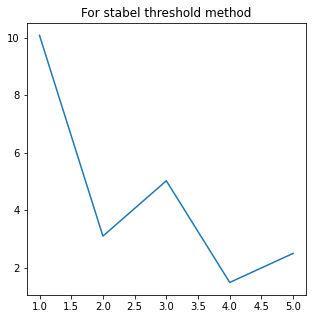

In [52]:
plt.figure(figsize=(5,5))
plt.plot(x, y_thresh_stable[0])
plt.title("For stabel threshold method")
plt.show()

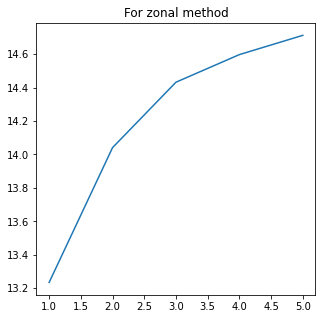

In [53]:
plt.figure(figsize=(5,5))
plt.plot(x, y_zonal[0])
plt.title("For zonal method")
plt.show()

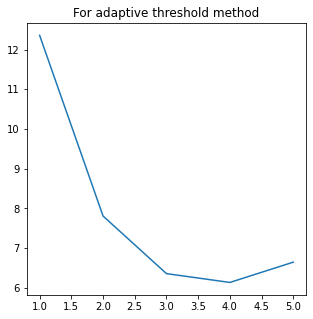

In [54]:
plt.figure(figsize=(5,5))
plt.plot(x, y_thresh_adaptive[0])
plt.title("For adaptive threshold method")
plt.show()

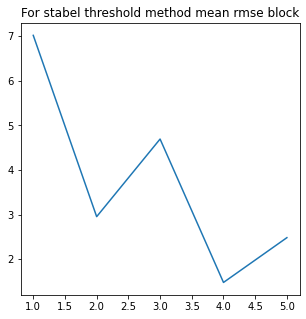

In [55]:
plt.figure(figsize=(5,5))
plt.plot(x, y_thresh_stabel_MEAN_RMSE_BLOCK[0])
plt.title("For stabel threshold method mean rmse block")
plt.show()

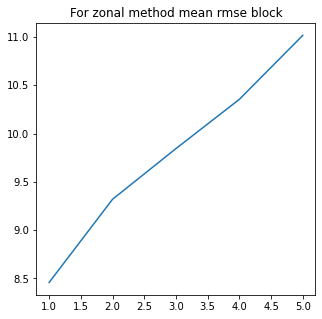

In [56]:
plt.figure(figsize=(5,5))
plt.plot(x, y_zonal_MEAN_RMSE_BLOCK[0])
plt.title("For zonal method mean rmse block")
plt.show()

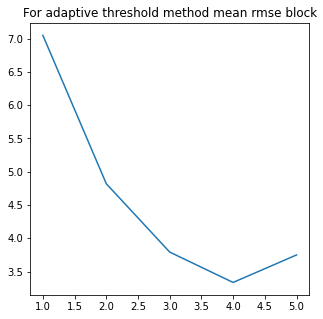

In [57]:
plt.figure(figsize=(5,5))
plt.plot(x, y_thresh_adaptive_MEAN_RMSE_BLOCK[0])
plt.title("For adaptive threshold method mean rmse block")
plt.show()